### Fund holdings and MSCI data
* This notebook includes all the steps from constructing the final dataset to descriptive statistics for MSCI ESG data.

---

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)
from scipy.stats import pearsonr

### Load fund and ESG data

In [71]:
msci_data = pd.read_csv('../data/msci_data_subset.csv')

In [72]:
msci_data = msci_data.dropna()

In [73]:
fund_header = pd.read_csv('../data/fund_hdr_table.csv')
holdings_data = pd.read_csv('../data/holdings_data.csv', dtype={'maturity_dt': str})

In [74]:
fund_style_equity_only = pd.read_csv('../data/fund_style_equity_only.csv')

### Keywords used to filter for ESG funds

In [75]:
check_list = ["SRI", "social", "ESG", "green", "sustain", "environ", "impact", "responsible", "clean", "renewable"]

In [76]:
'|'.join(check_list)

'SRI|social|ESG|green|sustain|environ|impact|responsible|clean|renewable'

In [77]:
listed_esg_fund_names = fund_header[fund_header.fund_name.str.contains('|'.join(check_list), case=False, regex=True)]

In [78]:
len(listed_esg_fund_names)

1783

In [79]:
# fund style/strategy included in research
styles = ['growth', 'income', 'small', 'mid']

In [80]:
fund_style_subset = fund_style_equity_only[fund_style_equity_only.lipper_obj_name.str.contains('|'.join(styles), case=False, regex=True)]

In [81]:
len(fund_style_subset)

61198

In [82]:
# get domestic funds with 'ED', 'ED' being equity, domestic
domestic_fund_style_subset = fund_style_subset[fund_style_subset['crsp_obj_cd'].str.contains('ED')]

In [83]:
len(domestic_fund_style_subset)

57495

In [84]:
domestic_fund_style_subset['lipper_obj_name'].value_counts()

GROWTH FUNDS               15076
GROWTH & INCOME FUNDS      11855
Growth Funds                7440
MID-CAP FUNDS               5761
SMALL-CAP FUNDS             5294
Growth and Income Funds     4329
Small-Cap Funds             3383
Mid-Cap Funds               2414
EQUITY INCOME FUNDS         1313
Equity Income Funds          630
Name: lipper_obj_name, dtype: int64

In [85]:
# map fund style to fund name on crsp_fundno

In [86]:
fund_name_style_table = domestic_fund_style_subset.merge(listed_esg_fund_names, how='inner', on='crsp_fundno', validate='m:1')

In [87]:
fund_name_style_table.shape

(1319, 38)

In [88]:
fund_name_style_table['lipper_obj_name'].value_counts()

GROWTH FUNDS               572
Growth Funds               212
GROWTH & INCOME FUNDS      181
MID-CAP FUNDS               90
Growth and Income Funds     81
SMALL-CAP FUNDS             60
Small-Cap Funds             49
EQUITY INCOME FUNDS         38
Mid-Cap Funds               32
Equity Income Funds          4
Name: lipper_obj_name, dtype: int64

In [89]:
len(fund_name_style_table.crsp_fundno.unique())

642

### Funds with each of it's classes

In [90]:
fund_name_style_table.groupby(['crsp_fundno', 'lipper_class_name'])['lipper_class_name'].nunique().to_frame()

,,lipper_class_name
crsp_fundno,lipper_class_name,
606,Equity Income Funds,1
607,Equity Income Funds,1
608,Equity Income Funds,1
662,Large-Cap Core Funds,1
666,Mid-Cap Growth Funds,1
...,...,...
99877,Large-Cap Value Funds,1
99990,Multi-Cap Core Funds,1
100036,Large-Cap Core Funds,1


### Fund name and holdings data merged

In [91]:
fund_name_style_table = fund_name_style_table.loc[:, ['crsp_fundno', 'fund_name', 'crsp_portno', 'crsp_obj_cd', 
                                     'lipper_class_name', 'lipper_obj_name', 'lipper_asset_cd']]

In [92]:
fund_name_style_table['lipper_obj_name'] = fund_name_style_table['lipper_obj_name'].str.lower()

In [93]:
fund_name_style_table.loc[fund_name_style_table['lipper_obj_name']=='growth & income funds', 'lipper_obj_name'] = 'growth and income funds'

In [94]:
fund_name_style_table = fund_name_style_table.drop_duplicates().dropna(subset='crsp_portno')

In [95]:
fund_name_style_table.lipper_obj_name.unique()

array(['growth funds', 'growth and income funds', 'small-cap funds',
       'mid-cap funds', 'equity income funds'], dtype=object)

In [96]:
fund_name_style_table = fund_name_style_table.drop_duplicates(subset=['crsp_portno'])

In [97]:
fund_and_holdings_table = fund_name_style_table.merge(holdings_data, how='inner', on='crsp_portno')

In [98]:
#here I have 19712 unique securities

In [99]:
len(fund_and_holdings_table.security_name.unique())

19712

In [100]:
# not an ESG fund
to_drop = 'Valued Advisers Trust: Green Owl Intrinsic Value Fund'

In [101]:
fund_and_holdings_table = fund_and_holdings_table.drop(
    fund_and_holdings_table[fund_and_holdings_table['fund_name'] == to_drop].index
)

### I identify 197 funds

In [102]:
fund_and_holdings_table.loc[:, ['crsp_fundno', 'fund_name', 'lipper_class_name']].drop_duplicates().to_excel('active_fund_names.xlsx', index=False)

In [103]:
fund_and_holdings_table.groupby(['crsp_fundno', 'lipper_class_name'])['lipper_class_name'].nunique().to_frame()

,,lipper_class_name
crsp_fundno,lipper_class_name,
3946,Large-Cap Growth Funds,1
3955,Multi-Cap Growth Funds,1
5031,Large-Cap Core Funds,1
6718,Multi-Cap Growth Funds,1
6876,Multi-Cap Value Funds,1
...,...,...
99856,Mid-Cap Core Funds,1
99860,Mid-Cap Core Funds,1
99861,Mid-Cap Core Funds,1


In [104]:
final_fund_holdings_table_short = fund_and_holdings_table.loc[:, ['crsp_fundno', 'report_dt', 'nbr_shares', 'security_name', 'cusip', 'ticker']]

In [105]:
final_fund_holdings_table_short

,crsp_fundno,report_dt,nbr_shares,security_name,cusip,ticker
0,3946,2009/10/31,6365,APPLE INC,03783310,AAPL
1,3946,2009/10/31,38330,MICROSOFT CORP,59491810,MSFT
2,3946,2009/10/31,1370,GOOGLE INC,38259P50,GOOG
3,3946,2009/10/31,13660,WAL MART STORES INC,93114210,WMT
4,3946,2009/10/31,13250,TARGET CORP,87612E10,TGT
...,...,...,...,...,...,...
2330943,100115,2022/06/30,28,Aptiv PLC ORD,G6095L10,APTV
2330944,100115,2022/06/30,36,Ball Corp ORD,05849810,BALL
2330945,100115,2022/06/30,210,Orange SA ORD,F6866T10,ORAN
2330946,100115,2022/06/30,54,International Paper Co ORD,46014610,IP


In [106]:
final_fund_holdings_table_short['year_month'] = pd.to_datetime([x[:7] for x in final_fund_holdings_table_short.report_dt])

In [107]:
final_fund_holdings_table_short['year_month'] = final_fund_holdings_table_short['year_month'].dt.to_period('M')

In [108]:
final_fund_holdings_table_short = final_fund_holdings_table_short.drop('report_dt', axis=1)

In [109]:
final_fund_holdings_table_short

,crsp_fundno,nbr_shares,security_name,cusip,ticker,year_month
0,3946,6365,APPLE INC,03783310,AAPL,2009-10
1,3946,38330,MICROSOFT CORP,59491810,MSFT,2009-10
2,3946,1370,GOOGLE INC,38259P50,GOOG,2009-10
3,3946,13660,WAL MART STORES INC,93114210,WMT,2009-10
4,3946,13250,TARGET CORP,87612E10,TGT,2009-10
...,...,...,...,...,...,...
2330943,100115,28,Aptiv PLC ORD,G6095L10,APTV,2022-06
2330944,100115,36,Ball Corp ORD,05849810,BALL,2022-06
2330945,100115,210,Orange SA ORD,F6866T10,ORAN,2022-06
2330946,100115,54,International Paper Co ORD,46014610,IP,2022-06


### Load additional input to obtain ISIN

In [110]:
sec = pd.read_csv(r"C:\Users\johnd\PycharmProjects\pythonproject\Basecamp\sec_header.csv")

In [111]:
sec = sec.drop_duplicates(subset='scusip')

In [112]:
sec

,scusip,tic,isin
0,000032102,AE.2,NaN
1,000165100,AMFD.,US0001651001
2,000354100,ANTQ,US0003541002
3,000361105,AIR,US0003611052
4,000781104,ABSI.1,US0007811047
...,...,...,...
47450,67013H114,NOW.WT,CA67013H1148
47451,37428A103,GET,US37428A1034
47452,74907L102,QNRX,US74907L1026
47453,67578E100,ODDAF,CA67578E1007


In [113]:
final_fund_holdings_table_short.cusip.drop_duplicates().dropna().to_excel('cusip_8.xlsx', index=False)

### Load cusip_9 obtained using cusip_8 and cusip converter

In [114]:
cusip_9_digit = pd.read_csv('../data/cusip_9_overall_redone.csv')

In [115]:
cusip_9_digit = cusip_9_digit.rename(columns={'cusip':'cusip_9'})

In [116]:
cusip_9_digit['cusip_8'] = [x[:8] for x in cusip_9_digit['cusip_9']]

In [117]:
cusip_and_isins = cusip_9_digit.merge(sec, how='inner', left_on='cusip_9', right_on='scusip', validate='1:1')

In [118]:
cusip_and_isins

,cusip_9,cusip_8,scusip,tic,isin
0,000307108,00030710,000307108,AACH,US0003071083
1,000360206,00036020,000360206,AAON,US0003602069
2,000361105,00036110,000361105,AIR,US0003611052
3,000375204,00037520,000375204,ABB,US0003752047
4,000380204,00038020,000380204,ABCM,US0003802040
...,...,...,...,...,...
6594,Y8564W103,Y8564W10,Y8564W103,TK,MHY8564W1030
6595,Y8565N300,Y8565N30,Y8565N300,TNK,MHY8565N3002
6596,Y8897Y180,Y8897Y18,Y8897Y180,TOPS,MHY8897Y1804
6597,Y93691106,Y9369110,Y93691106,VRGY,SG9999002885


In [119]:
# merge above table with msci data

In [120]:
msci_isin_mapped = msci_data.merge(cusip_and_isins, how='inner', left_on='ISIN', right_on='isin', validate='m:1')

In [121]:
len(msci_isin_mapped)

60778

In [122]:
len(msci_isin_mapped.drop_duplicates(subset='isin'))

1038

In [123]:
msci_isin_mapped

,Analysis Date,ISIN,Asset Name,Company Rating,Industry Adjusted Score,cusip_9,cusip_8,scusip,tic,isin
0,2013-12-31,CA0679011084,BARRICK GOLD CORP,B,2.3,067901108,06790110,067901108,GOLD,CA0679011084
1,2014-01-31,CA0679011084,BARRICK GOLD CORP,B,2.3,067901108,06790110,067901108,GOLD,CA0679011084
2,2014-02-28,CA0679011084,BARRICK GOLD CORP,B,2.3,067901108,06790110,067901108,GOLD,CA0679011084
3,2014-03-31,CA0679011084,BARRICK GOLD CORP,B,2.3,067901108,06790110,067901108,GOLD,CA0679011084
4,2014-04-30,CA0679011084,BARRICK GOLD CORP,B,2.4,067901108,06790110,067901108,GOLD,CA0679011084
...,...,...,...,...,...,...,...,...,...,...
60773,2020-12-31,US29786A1060,ETSY INC,BBB,5.5,29786A106,29786A10,29786A106,ETSY,US29786A1060
60774,2020-12-31,CA33767E2024,FIRSTSERVICE CORP,A,6.9,33767E202,33767E20,33767E202,FSV,CA33767E2024
60775,2020-12-31,JE00BYSS4X48,NOVOCURE LTD,BBB,4.7,G6674U108,G6674U10,G6674U108,NVCR,JE00BYSS4X48
60776,2020-12-31,US1468691027,CARVANA CO,B,2.4,146869102,14686910,146869102,CVNA,US1468691027


In [124]:
msci_isin_mapped['year_month'] = pd.to_datetime([x[:7] for x in msci_isin_mapped['Analysis Date']])

In [125]:
msci_isin_mapped['year_month'] = msci_isin_mapped['year_month'].dt.to_period('M')

In [126]:
msci_isin_mapped

,Analysis Date,ISIN,Asset Name,Company Rating,Industry Adjusted Score,cusip_9,cusip_8,scusip,tic,isin,year_month
0,2013-12-31,CA0679011084,BARRICK GOLD CORP,B,2.3,067901108,06790110,067901108,GOLD,CA0679011084,2013-12
1,2014-01-31,CA0679011084,BARRICK GOLD CORP,B,2.3,067901108,06790110,067901108,GOLD,CA0679011084,2014-01
2,2014-02-28,CA0679011084,BARRICK GOLD CORP,B,2.3,067901108,06790110,067901108,GOLD,CA0679011084,2014-02
3,2014-03-31,CA0679011084,BARRICK GOLD CORP,B,2.3,067901108,06790110,067901108,GOLD,CA0679011084,2014-03
4,2014-04-30,CA0679011084,BARRICK GOLD CORP,B,2.4,067901108,06790110,067901108,GOLD,CA0679011084,2014-04
...,...,...,...,...,...,...,...,...,...,...,...
60773,2020-12-31,US29786A1060,ETSY INC,BBB,5.5,29786A106,29786A10,29786A106,ETSY,US29786A1060,2020-12
60774,2020-12-31,CA33767E2024,FIRSTSERVICE CORP,A,6.9,33767E202,33767E20,33767E202,FSV,CA33767E2024,2020-12
60775,2020-12-31,JE00BYSS4X48,NOVOCURE LTD,BBB,4.7,G6674U108,G6674U10,G6674U108,NVCR,JE00BYSS4X48,2020-12
60776,2020-12-31,US1468691027,CARVANA CO,B,2.4,146869102,14686910,146869102,CVNA,US1468691027,2020-12


In [127]:
# idea is to match to fund table to get number of shares held

In [128]:
companies_in_both_frames = (final_fund_holdings_table_short.drop_duplicates(subset='cusip').merge(msci_isin_mapped.drop_duplicates(subset='isin'),
                                                                      left_on='cusip', right_on='cusip_8', validate='1:1'))

In [129]:
# identify companies from fund_holdings table for which you have msci ratings (basically from msci_isin_mapped table)

In [130]:
required_fund_holdings_table = final_fund_holdings_table_short.set_index('cusip').loc[companies_in_both_frames['cusip']]

In [131]:
required_fund_holdings_table = required_fund_holdings_table.reset_index().sort_values(['crsp_fundno', 'cusip'])

In [132]:
required_fund_holdings_table

,cusip,crsp_fundno,nbr_shares,security_name,ticker,year_month
46517,00282410,3946,7800,ABBOTT LABORATORIES,ABT,2009-10
46518,00282410,3946,8450,ABBOTT LABORATORIES,ABT,2010-01
46519,00282410,3946,9345,ABBOTT LABORATORIES,ABT,2010-04
46520,00282410,3946,9345,ABBOTT LABORATORIES,ABT,2010-06
46521,00282410,3946,9345,ABBOTT LABORATORIES,ABT,2010-07
...,...,...,...,...,...,...
1147911,H4209710,100115,434,UBS Group AG ORD,UBSG,2022-06
1143326,J4387311,100115,600,Mitsubishi Electric Corp ORD,6503,2022-06
1146194,J7637910,100115,200,Sony Group Corp ORD,6758,2022-06
1143364,J9267611,100115,600,Toyota Motor Corp ORD,7203,2022-06


### I drop observations with negative number of shares.

In [133]:
required_fund_holdings_table = required_fund_holdings_table[~required_fund_holdings_table.nbr_shares<0]

In [134]:
agg_holdings = required_fund_holdings_table.groupby(['cusip', 'year_month'])['nbr_shares'].sum().to_frame().reset_index()

In [135]:
agg_holdings

,cusip,year_month,nbr_shares
0,00101J10,2012-10,172179
1,00101J10,2012-11,89472
2,00101J10,2012-12,224694
3,00101J10,2013-01,96886
4,00101J10,2013-02,79250
...,...,...,...
119066,Y2573F10,2022-02,946700
119067,Y2573F10,2022-03,800811
119068,Y2573F10,2022-04,1167982
119069,Y2573F10,2022-05,956484


In [136]:
# these cusips have just one observation
for x in agg_holdings['cusip'].drop_duplicates():
    table_1 = agg_holdings.set_index('cusip').loc[x]
    if type(table_1) == pd.core.series.Series:
        print(x)

21037X10
45303840
55270410
89346D10
B639CJ10
G0694010


### Important step: do a forward fill to obtain full time-series of fund data

In [137]:
%%time
esg_fund_time_series = []
for x in agg_holdings['cusip'].drop_duplicates():
    table_1 = agg_holdings.set_index('cusip').loc[x]
    if type(table_1) != pd.core.series.Series:
        table_1 = table_1.drop_duplicates(subset='year_month').reset_index().set_index('year_month').resample('M').ffill()
        esg_fund_time_series.append(table_1)
    print('completed',len(esg_fund_time_series))

completed 1
completed 2
completed 3
completed 4
completed 5
completed 6
completed 7
completed 8
completed 9
completed 10
completed 11
completed 12
completed 13
completed 14
completed 15
completed 16
completed 17
completed 18
completed 19
completed 20
completed 21
completed 22
completed 23
completed 24
completed 25
completed 26
completed 27
completed 28
completed 29
completed 30
completed 31
completed 32
completed 33
completed 34
completed 35
completed 36
completed 37
completed 38
completed 39
completed 40
completed 41
completed 42
completed 43
completed 44
completed 45
completed 46
completed 47
completed 48
completed 49
completed 50
completed 51
completed 52
completed 53
completed 54
completed 55
completed 56
completed 57
completed 58
completed 59
completed 60
completed 61
completed 62
completed 63
completed 64
completed 65
completed 66
completed 67
completed 68
completed 69
completed 70
completed 71
completed 72
completed 73
completed 74
completed 75
completed 76
completed 77
complete

completed 595
completed 596
completed 597
completed 598
completed 599
completed 600
completed 601
completed 602
completed 603
completed 604
completed 605
completed 606
completed 607
completed 608
completed 609
completed 610
completed 611
completed 612
completed 613
completed 614
completed 615
completed 616
completed 617
completed 618
completed 619
completed 620
completed 621
completed 622
completed 623
completed 624
completed 625
completed 626
completed 627
completed 628
completed 629
completed 630
completed 631
completed 632
completed 633
completed 634
completed 635
completed 636
completed 637
completed 638
completed 639
completed 640
completed 641
completed 642
completed 643
completed 644
completed 645
completed 646
completed 647
completed 648
completed 649
completed 650
completed 651
completed 652
completed 653
completed 654
completed 655
completed 656
completed 657
completed 658
completed 659
completed 660
completed 661
completed 662
completed 663
completed 664
completed 665
comple

In [138]:
agg_holdings = pd.concat(esg_fund_time_series).reset_index()

In [139]:
agg_holdings

,year_month,cusip,nbr_shares
0,2012-10,00101J10,172179
1,2012-11,00101J10,89472
2,2012-12,00101J10,224694
3,2013-01,00101J10,96886
4,2013-02,00101J10,79250
...,...,...,...
134180,2022-02,Y2573F10,946700
134181,2022-03,Y2573F10,800811
134182,2022-04,Y2573F10,1167982
134183,2022-05,Y2573F10,956484


In [140]:
required_msci_isin_mapped = msci_isin_mapped.loc[:,['year_month','cusip_8', 'ISIN', 'Asset Name', 'Company Rating', 'Industry Adjusted Score']].sort_values(['cusip_8', 'year_month'])

In [141]:
required_msci_isin_mapped = required_msci_isin_mapped.groupby(['cusip_8', 'year_month']).value_counts().to_frame().drop(0, axis=1).reset_index()

In [142]:
required_msci_isin_mapped

,cusip_8,year_month,ISIN,Asset Name,Company Rating,Industry Adjusted Score
0,00101J10,2013-12,US00101J1060,ADT CORP,BBB,4.4
1,00101J10,2014-01,US00101J1060,ADT CORP,BBB,4.4
2,00101J10,2014-02,US00101J1060,ADT CORP,BBB,4.4
3,00101J10,2014-03,US00101J1060,ADT CORP,BBB,4.4
4,00101J10,2014-04,US00101J1060,ADT CORP,BBB,4.4
...,...,...,...,...,...,...
60773,Y2573F10,2020-01,SG9999000020,FLEX LTD,A,6.1
60774,Y2573F10,2020-02,SG9999000020,FLEX LTD,A,6.9
60775,Y2573F10,2020-03,SG9999000020,FLEX LTD,A,6.9
60776,Y2573F10,2020-04,SG9999000020,FLEX LTD,A,6.9


In [143]:
len([x for x in agg_holdings['cusip'].drop_duplicates()])

1032

In [144]:
final_table_for_stata = agg_holdings.merge(required_msci_isin_mapped, how='inner', left_on=['cusip', 'year_month'], right_on=['cusip_8', 'year_month'], validate='1:1')

In [145]:
final_table_for_stata

,year_month,cusip,nbr_shares,cusip_8,ISIN,Asset Name,Company Rating,Industry Adjusted Score
0,2013-12,00101J10,257774,00101J10,US00101J1060,ADT CORP,BBB,4.4
1,2014-01,00101J10,179271,00101J10,US00101J1060,ADT CORP,BBB,4.4
2,2014-02,00101J10,164422,00101J10,US00101J1060,ADT CORP,BBB,4.4
3,2014-03,00101J10,84622,00101J10,US00101J1060,ADT CORP,BBB,4.4
4,2014-04,00101J10,43988,00101J10,US00101J1060,ADT CORP,BBB,4.4
...,...,...,...,...,...,...,...,...
55339,2020-01,Y2573F10,558887,Y2573F10,SG9999000020,FLEX LTD,A,6.1
55340,2020-02,Y2573F10,505041,Y2573F10,SG9999000020,FLEX LTD,A,6.9
55341,2020-03,Y2573F10,492730,Y2573F10,SG9999000020,FLEX LTD,A,6.9
55342,2020-04,Y2573F10,656605,Y2573F10,SG9999000020,FLEX LTD,A,6.9


In [146]:
final_table_for_stata.cusip.drop_duplicates().to_excel('cusip_for_monthly_stock_data_msci.xlsx', index=False)

### Load input for monthly stock data obtained using cusip

In [147]:
shrout = pd.read_csv('../data/all_monthly_stock_data_2.csv')

In [148]:
shrout['year_month'] = pd.to_datetime(shrout['MthCalDt'], format='%Y/%m/%d').dt.to_period('M')

In [149]:
shrout.head()

,HdrCUSIP,CUSIP,CUSIP9,MthCalDt,MthPrc,MthCap,ShrOut,year_month
0,68389X10,68389X10,68389X105,2013/12/31,38.2600,"172,070,868.34","4,497,409",2013-12
1,68389X10,68389X10,68389X105,2014/01/31,36.9000,"165,954,392.10","4,497,409",2014-01
2,68389X10,68389X10,68389X105,2014/02/28,39.1100,"175,893,665.99","4,497,409",2014-02
3,68389X10,68389X10,68389X105,2014/03/31,40.9100,"182,413,026.26","4,458,886",2014-03
4,68389X10,68389X10,68389X105,2014/04/30,40.8800,"182,279,259.68","4,458,886",2014-04


In [150]:
required_shrout = shrout.loc[:, ['CUSIP', 'CUSIP9', 'year_month', 'MthPrc', 'MthCap', 'ShrOut']]

In [151]:
required_shrout.isna().sum()

CUSIP           0
CUSIP9          0
year_month      0
MthPrc          0
MthCap          0
ShrOut        152
dtype: int64

In [ ]:
#instead of dropping, one could manually calculate the missing 152 outstanding shares by dividing mthcap by mthprc.
#since the original study does not mention this step in their dataset construction, I use the data as obtained from the source.

In [152]:
required_shrout = required_shrout.dropna(subset='ShrOut')

In [153]:
final_table_stata_and_shrout = final_table_for_stata.merge(required_shrout, how='inner', left_on=['cusip', 'year_month'], right_on=['CUSIP', 'year_month'])

In [154]:
# got data for all 911 firms

In [155]:
final_table_stata_and_shrout.cusip.drop_duplicates()

0        00101J10
29       00105510
114      00108410
174      00120410
181      00123Q10
           ...   
51627    N5374510
51712    N6596X10
51771    N7248212
51810    V7780T10
51895    Y2573F10
Name: cusip, Length: 911, dtype: object

In [156]:
esg_grade_changes_dict_map = {'AAA':7, 
                              'AA':6, 
                              'A':5,
                              'BBB':4,
                             'BB':3,
                             'B':2,
                             'CCC':1}
final_table_stata_and_shrout['esg_grade_num'] = final_table_stata_and_shrout['Company Rating'].map(esg_grade_changes_dict_map)

### Identifying the rating changes

In [157]:
# source: https://stackoverflow.com/questions/48673046/get-index-where-value-changes-in-pandas-dataframe-column
changes = {}

for col in ['Company Rating']:
    changes[col] = [0] + [idx for idx, (i, j) in enumerate(zip(final_table_stata_and_shrout[col], final_table_stata_and_shrout[col][1:]), 1) if i != j]

for col in ['esg_grade_num']:
    changes['upgrade'] = [idx for idx, (i, j) in enumerate(zip(final_table_stata_and_shrout[col], final_table_stata_and_shrout[col][1:]), 1) if i < j] 

for col in ['esg_grade_num']:
    changes['downgrade'] = [idx for idx, (i, j) in enumerate(zip(final_table_stata_and_shrout[col], final_table_stata_and_shrout[col][1:]), 1) if i > j]        

In [158]:
upgrade_frame = pd.DataFrame({x:'upgrade' for x in changes['upgrade']}, index=[0]).T
downgrade_frame = pd.DataFrame({x:'downgrade' for x in changes['downgrade']}, index=[0]).T
upgrades_and_downgrades = pd.concat([upgrade_frame,downgrade_frame]).rename(columns={0:'up_or_down'})
upgrades_and_downgrades.loc[upgrades_and_downgrades['up_or_down']=='upgrade', 'upgrade_dummy'] = 1
upgrades_and_downgrades.loc[upgrades_and_downgrades['up_or_down']=='downgrade', 'downgrade_dummy'] = 1

In [159]:
upgrades_and_downgrades['upgrade_dummy'] = upgrades_and_downgrades['upgrade_dummy'].fillna(0).astype(int)
upgrades_and_downgrades['downgrade_dummy'] = upgrades_and_downgrades['downgrade_dummy'].fillna(0).astype(int)
upgrades_and_downgrades

,up_or_down,upgrade_dummy,downgrade_dummy
28,upgrade,1,0
98,upgrade,1,0
106,upgrade,1,0
118,upgrade,1,0
232,upgrade,1,0
...,...,...,...
51810,downgrade,0,1
51832,downgrade,0,1
51891,downgrade,0,1
51900,downgrade,0,1


In [160]:
# obs where esg_grade changes
esg_grade_changes = final_table_stata_and_shrout.iloc[changes['Company Rating']].copy()

In [161]:
esg_grade_changes = pd.concat([esg_grade_changes, upgrades_and_downgrades], axis=1)

In [162]:
esg_grade_changes

,year_month,cusip,nbr_shares,cusip_8,ISIN,Asset Name,Company Rating,Industry Adjusted Score,CUSIP,CUSIP9,MthPrc,MthCap,ShrOut,esg_grade_num,up_or_down,upgrade_dummy,downgrade_dummy
0,2013-12,00101J10,257774,00101J10,US00101J1060,ADT CORP,BBB,4.4,00101J10,00101J106,40.4700,"8,165,389.08","201,764",4,NaN,NaN,NaN
28,2016-04,00101J10,71288,00101J10,US00101J1060,ADT CORP,A,7.0,00101J10,00101J106,41.9800,"6,949,621.08","165,546",5,upgrade,1.0,0.0
29,2013-12,00105510,568705,00105510,US0010551028,AFLAC INC,BBB,4.3,00105510,001055102,66.8000,"31,134,812.00","466,090",4,downgrade,0.0,1.0
64,2016-11,00105510,362767,00105510,US0010551028,AFLAC INC,BB,3.4,00105510,001055102,71.3800,"29,130,320.76","408,102",3,downgrade,0.0,1.0
82,2018-05,00105510,916289,00105510,US0010551028,AFLAC INC,B,2.7,00105510,001055102,45.0600,"34,883,965.02","774,167",2,downgrade,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51891,2020-09,V7780T10,598546,V7780T10,LR0008862868,ROYAL CARIBBEAN GROUP,BB,4.0,V7780T10,V7780T103,64.7300,"13,895,459.64","214,668",3,downgrade,0.0,1.0
51895,2013-12,Y2573F10,143785,Y2573F10,SG9999000020,FLEX LTD,AA,8.0,Y2573F10,Y2573F102,7.7700,"4,679,319.33","602,229",6,upgrade,1.0,0.0
51900,2014-05,Y2573F10,169495,Y2573F10,SG9999000020,FLEX LTD,A,6.1,Y2573F10,Y2573F102,10.1700,"5,954,097.69","585,457",5,downgrade,0.0,1.0
51911,2015-04,Y2573F10,220174,Y2573F10,SG9999000020,FLEX LTD,AA,8.4,Y2573F10,Y2573F102,11.5250,"6,492,297.58","563,323",6,upgrade,1.0,0.0


In [163]:
# concat treatment dates into final table

In [164]:
final_table_stata_and_shrout = final_table_stata_and_shrout.drop(['CUSIP', 'CUSIP9'], axis=1)

### Shares outstanding (shrout) is in thousands
* https://www.crsp.org/files/data_descriptions_guide_0.pdf

In [165]:
final_table_stata_and_shrout['ShrOut'] = final_table_stata_and_shrout['ShrOut'].apply(lambda x: x.replace(',', ''))

In [166]:
final_table_stata_and_shrout = final_table_stata_and_shrout.apply(pd.to_numeric, errors='ignore')

In [167]:
final_table_stata_and_shrout['esg_ownership'] = final_table_stata_and_shrout['nbr_shares']/(final_table_stata_and_shrout['ShrOut']*1000)
final_table_stata_and_shrout['esg_ownership_(%)'] = final_table_stata_and_shrout['esg_ownership']*100

In [168]:
final_table_stata_and_shrout

,year_month,cusip,nbr_shares,cusip_8,ISIN,Asset Name,Company Rating,Industry Adjusted Score,MthPrc,MthCap,ShrOut,esg_grade_num,esg_ownership,esg_ownership_(%)
0,2013-12,00101J10,257774,00101J10,US00101J1060,ADT CORP,BBB,4.4,40.4700,"8,165,389.08",201764,4,0.001278,0.127760
1,2014-01,00101J10,179271,00101J10,US00101J1060,ADT CORP,BBB,4.4,30.0400,"5,506,632.40",183310,4,0.000978,0.097797
2,2014-02,00101J10,164422,00101J10,US00101J1060,ADT CORP,BBB,4.4,30.7100,"5,629,450.10",183310,4,0.000897,0.089696
3,2014-03,00101J10,84622,00101J10,US00101J1060,ADT CORP,BBB,4.4,29.9500,"5,490,134.50",183310,4,0.000462,0.046163
4,2014-04,00101J10,43988,00101J10,US00101J1060,ADT CORP,BBB,4.4,30.2400,"5,269,199.04",174246,4,0.000252,0.025245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51968,2020-01,Y2573F10,558887,Y2573F10,SG9999000020,FLEX LTD,A,6.1,13.1500,"6,627,494.80",503992,5,0.001109,0.110892
51969,2020-02,Y2573F10,505041,Y2573F10,SG9999000020,FLEX LTD,A,6.9,11.1100,"5,599,351.12",503992,5,0.001002,0.100208
51970,2020-03,Y2573F10,492730,Y2573F10,SG9999000020,FLEX LTD,A,6.9,8.3750,"4,165,942.75",497426,5,0.000991,0.099056
51971,2020-04,Y2573F10,656605,Y2573F10,SG9999000020,FLEX LTD,A,6.9,9.7600,"4,854,877.76",497426,5,0.001320,0.132001


In [169]:
final_table_stata_and_shrout.describe().T.apply(lambda x: x.map('{:.2f}'.format))

,count,mean,std,min,25%,50%,75%,max
nbr_shares,51973.00,512057.89,992663.27,15.00,59424.00,180707.00,517430.00,29169397.00
Industry Adjusted Score,51973.00,4.83,2.18,0.00,3.20,4.70,6.40,10.00
ShrOut,51973.00,546776.83,940510.07,3590.00,141458.00,270086.00,531284.00,17102536.00
esg_grade_num,51973.00,3.85,1.46,1.00,3.00,4.00,5.00,7.00
esg_ownership,51973.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02
esg_ownership_(%),51973.00,0.11,0.14,0.00,0.03,0.07,0.14,1.95


In [170]:
esg_grade_changes = esg_grade_changes.rename(columns={'year_month': 'treatment_date', 'cusip':'cusip_grade_change'})

In [171]:
# set first month of each security as untreated.
esg_grade_changes.loc[esg_grade_changes.drop_duplicates('cusip_grade_change').index, ['up_or_down', 'upgrade_dummy', 'downgrade_dummy']] = 0

In [172]:
esg_grade_changes.loc[esg_grade_changes['up_or_down']==0, 'treatment_date']= np.nan

In [173]:
esg_grade_changes = esg_grade_changes.loc[:, ['treatment_date', 'up_or_down', 'upgrade_dummy', 'downgrade_dummy']]

In [174]:
final_table_stata_and_shrout_all_changes = pd.concat([final_table_stata_and_shrout, esg_grade_changes], axis=1)

In [175]:
first_upgrade_index = final_table_stata_and_shrout_all_changes[final_table_stata_and_shrout_all_changes['up_or_down']=='upgrade'].drop_duplicates(subset=['cusip', 'up_or_down']).index

In [176]:
first_downgrade_index = final_table_stata_and_shrout_all_changes[final_table_stata_and_shrout_all_changes['up_or_down']=='downgrade'].drop_duplicates(subset=['cusip', 'up_or_down']).index

In [177]:
first_up_and_downgrade_list = list(first_upgrade_index) + list(first_downgrade_index)

In [178]:
first_up_and_downgrade_table = esg_grade_changes.loc[first_up_and_downgrade_list]

In [179]:
final_table_stata_and_shrout = pd.concat([final_table_stata_and_shrout, first_up_and_downgrade_table], axis=1)

In [180]:
final_table_stata_and_shrout.up_or_down = final_table_stata_and_shrout.up_or_down.fillna(0)
final_table_stata_and_shrout.upgrade_dummy = final_table_stata_and_shrout.upgrade_dummy.fillna(0).astype(int)
final_table_stata_and_shrout.downgrade_dummy = final_table_stata_and_shrout.downgrade_dummy.fillna(0).astype(int)

In [181]:
# here we only look at the first upgrade and downgrades (i.e. we only consider the initial treatment for each security)
# we do not consider multiple upgrades/downgrades for same security
final_table_stata_and_shrout.groupby(['cusip'])['up_or_down'].value_counts().to_frame().head(10)

up_or_down
cusip    up_or_down            
00101J10 0                   28
         upgrade              1
00105510 0                   83
         downgrade            1
         upgrade              1
00108410 0                   59
         downgrade            1
00120410 0                    7
00123Q10 0                   51
00130H10 0                   83

In [182]:
id_for_cusips_dict = {x:i for i,x in enumerate(final_table_stata_and_shrout.drop_duplicates('cusip').cusip, start=1)}

In [183]:
final_table_stata_and_shrout['ID'] = final_table_stata_and_shrout.cusip.map(id_for_cusips_dict)

In [184]:
final_table_stata_and_shrout.year_month = final_table_stata_and_shrout.year_month.dt.to_timestamp()
final_table_stata_and_shrout.treatment_date = final_table_stata_and_shrout.treatment_date.dt.to_timestamp()

In [185]:
final_table_stata_and_shrout = final_table_stata_and_shrout.drop('cusip_8', axis=1)

In [186]:
final_table_stata_and_shrout = final_table_stata_and_shrout.set_index(['ID', 'year_month']).reset_index()

In [187]:
final_table_stata_and_shrout = final_table_stata_and_shrout.drop_duplicates(subset=['ID', 'year_month'])

In [188]:
final_table_stata_and_shrout.shape

(51863, 18)

In [189]:
final_table_stata_and_shrout.up_or_down[final_table_stata_and_shrout.up_or_down==0] = None

In [190]:
# fill dates for upgrades and downgrades into two columns

In [191]:
treatment_dict_upgrade = (final_table_stata_and_shrout.drop_duplicates(['cusip', 'treatment_date']).set_index('up_or_down')
 .loc['upgrade',['cusip','treatment_date']]
 .reset_index()
 .set_index('cusip')
 .treatment_date
 .to_dict())

In [192]:
treatment_dict_downgrade = (final_table_stata_and_shrout.drop_duplicates(['cusip', 'treatment_date']).set_index('up_or_down')
 .loc['downgrade',['cusip','treatment_date']]
 .reset_index()
 .set_index('cusip')
 .treatment_date
 .to_dict())

In [193]:
final_table_stata_and_shrout['treatment_date_up'] = final_table_stata_and_shrout.cusip.map(treatment_dict_upgrade)

In [194]:
final_table_stata_and_shrout['treatment_date_down'] = final_table_stata_and_shrout.cusip.map(treatment_dict_downgrade)

In [195]:
# never treated units
never_treated_units = (final_table_stata_and_shrout[(final_table_stata_and_shrout.treatment_date_up.isna())
                              & (final_table_stata_and_shrout.treatment_date_down.isna())]
 .drop_duplicates(subset='cusip'))

In [196]:
final_table_stata_and_shrout = final_table_stata_and_shrout.rename(columns={
    'Company Rating':'company_rating', 
    'Industry Adjusted Score': 'industry_adjusted_score',
    'Asset Name':'asset_name',
    'esg_ownership_(%)': 'esg_ownership_percent'})

In [197]:
final_table_stata_and_shrout.to_stata('final_table_stata_and_shrout_msci.dta', write_index=False, convert_dates={'year_month':'tm', 'treatment_date':'tm', 'treatment_date_up':'tm', 'treatment_date_down':'tm'})

In [198]:
final_table_stata_and_shrout.to_csv('final_table_stata_and_shrout_msci.csv', index=False)

### Trimming esg_ownership variable at 1st and 99th percentiles for each month to remove outliers.

In [199]:
%%time
df_trimmed_for_outliers = []
for x in final_table_stata_and_shrout.year_month.drop_duplicates():
    df_trimmed_for_outliers.append(final_table_stata_and_shrout[(final_table_stata_and_shrout['year_month']==x)
                            & (final_table_stata_and_shrout['esg_ownership']<final_table_stata_and_shrout['esg_ownership'].quantile(0.99))
                            & (final_table_stata_and_shrout['esg_ownership']>final_table_stata_and_shrout['esg_ownership'].quantile(0.01))])

CPU times: total: 672 ms
Wall time: 1.02 s


In [200]:
%%time
final_table_trimmed_for_outliers = pd.concat(df_trimmed_for_outliers)

CPU times: total: 93.8 ms
Wall time: 321 ms


In [201]:
#final_table_trimmed_for_outliers.to_csv('final_table_trimmed_for_outliers_msci.csv', index=False)

In [202]:
final_table_trimmed_for_outliers.to_stata('final_table_trimmed_for_outliers_msci.dta', write_index=False, convert_dates={'year_month':'tm', 'treatment_date':'tm', 'treatment_date_up':'tm', 'treatment_date_down':'tm'})

In [203]:
final_table_trimmed_for_outliers

,ID,year_month,cusip,nbr_shares,ISIN,asset_name,company_rating,industry_adjusted_score,MthPrc,MthCap,ShrOut,esg_grade_num,esg_ownership,esg_ownership_percent,treatment_date,up_or_down,upgrade_dummy,downgrade_dummy,treatment_date_up,treatment_date_down
0,1,2013-12-01,00101J10,257774,US00101J1060,ADT CORP,BBB,4.4,40.4700,"8,165,389.08",201764,4,0.001278,0.127760,NaT,None,0,0,2016-04-01,NaT
29,2,2013-12-01,00105510,568705,US0010551028,AFLAC INC,BBB,4.3,66.8000,"31,134,812.00",466090,4,0.001220,0.122016,NaT,None,0,0,2019-09-01,2016-11-01
114,3,2013-12-01,00108410,228380,US0010841023,AGCO CORP,BBB,5.2,59.1900,"5,762,738.40",97360,4,0.002346,0.234573,NaT,None,0,0,NaT,2018-05-01
232,6,2013-12-01,00130H10,215396,US00130H1059,AES CORP,BB,3.1,14.5100,"10,482,633.42",722442,3,0.000298,0.029815,NaT,None,0,0,2015-09-01,2020-12-01
317,7,2013-12-01,00206R10,2934933,US00206R1023,AT&T INC,BB,4.1,35.1600,"185,222,880.00",5268000,3,0.000557,0.055712,NaT,None,0,0,2018-03-01,2017-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51608,905,2020-12-01,N3167Y10,44563,NL0011585146,FERRARI NV,BBB,4.5,229.5200,"42,403,360.96",184748,4,0.000241,0.024121,NaT,None,0,0,2019-06-01,NaT
51711,907,2020-12-01,N5374510,179540,NL0009434992,LYONDELLBASELL INDUSTRIES NV,BBB,4.6,91.6600,"30,607,015.54",333919,4,0.000538,0.053768,NaT,None,0,0,2016-11-01,NaT
51770,908,2020-12-01,N6596X10,910995,NL0009538784,NXP SEMICONDUCTORS NV,BB,4.2,159.0100,"44,598,329.75",280475,3,0.003248,0.324804,NaT,None,0,0,NaT,NaT
51809,909,2020-12-01,N7248212,17068,NL0012169213,QIAGEN NV,A,6.0,52.8500,"12,089,384.65",228749,5,0.000075,0.007461,NaT,None,0,0,NaT,NaT


### Descriptives and Figures

* Load balanced panel data 

In [204]:
balanced_panel = pd.read_stata("../notebooks/msci_results/balanced_sample_msci.dta")

In [205]:
balanced_panel.dtypes.iloc[:20]

ID                                  int32
year_month                 datetime64[ns]
cusip                              object
nbr_shares                          int32
ISIN                               object
asset_name                         object
company_rating                     object
industry_adjusted_score           float64
MthPrc                             object
MthCap                             object
ShrOut                              int32
esg_grade_num                       int32
esg_ownership                     float64
esg_ownership_percent             float64
treatment_date             datetime64[ns]
up_or_down                         object
upgrade_dummy                       int32
downgrade_dummy                     int32
treatment_date_up          datetime64[ns]
treatment_date_down        datetime64[ns]
dtype: object

In [206]:
balanced_panel.iloc[:, :20].describe().T.apply(lambda x: x.map('{:.3f}'.format))

,count,mean,std,min,25%,50%,75%,max
ID,11475.000,415.289,269.110,2.000,184.000,400.000,667.000,910.000
nbr_shares,11475.000,865248.459,1403487.574,600.000,127385.000,353704.000,995114.000,22038267.000
industry_adjusted_score,11475.000,4.883,2.113,0.000,3.300,4.800,6.500,10.000
ShrOut,11475.000,859487.990,1278810.193,22759.000,208437.500,402384.000,951904.000,8300724.000
esg_grade_num,11475.000,3.866,1.422,1.000,3.000,4.000,5.000,7.000
esg_ownership,11475.000,0.001,0.001,0.000,0.000,0.001,0.002,0.007
esg_ownership_percent,11475.000,0.116,0.103,0.000,0.045,0.083,0.153,0.669
upgrade_dummy,11475.000,0.012,0.108,0.000,0.000,0.000,0.000,1.000
downgrade_dummy,11475.000,0.012,0.108,0.000,0.000,0.000,0.000,1.000


In [207]:
final_table_trimmed_for_outliers.describe().T.apply(lambda x: x.map('{:.3f}'.format))

,count,mean,std,min,25%,50%,75%,max
ID,50825.000,442.245,261.962,1.000,211.000,443.000,667.000,911.000
nbr_shares,50825.000,504176.710,978632.529,27.000,60920.000,180784.000,508214.000,29169397.000
industry_adjusted_score,50825.000,4.821,2.176,0.000,3.200,4.700,6.400,10.000
ShrOut,50825.000,548895.658,943973.098,3590.000,142456.000,272985.000,531863.000,17102536.000
esg_grade_num,50825.000,3.844,1.455,1.000,3.000,4.000,5.000,7.000
esg_ownership,50825.000,0.001,0.001,0.000,0.000,0.001,0.001,0.007
esg_ownership_percent,50825.000,0.105,0.111,0.000,0.030,0.069,0.138,0.678
upgrade_dummy,50825.000,0.009,0.096,0.000,0.000,0.000,0.000,1.000
downgrade_dummy,50825.000,0.006,0.078,0.000,0.000,0.000,0.000,1.000


### Similar to the authors
* The funds jointly own 0.15 % of TESLA shares

In [208]:
balanced_panel[(balanced_panel['asset_name'].str.contains('TESLA'))
                                & (balanced_panel['year_month']=='2020-09-01')].T.iloc[:20]

,9346
ID,735
year_month,2020-09-01 00:00:00
cusip,88160R10
nbr_shares,1415203
ISIN,US88160R1014
asset_name,TESLA INC
company_rating,A
industry_adjusted_score,7.1
MthPrc,429.0100
MthCap,"406,701,480.00"


In [209]:
## plot with outliers trimmed

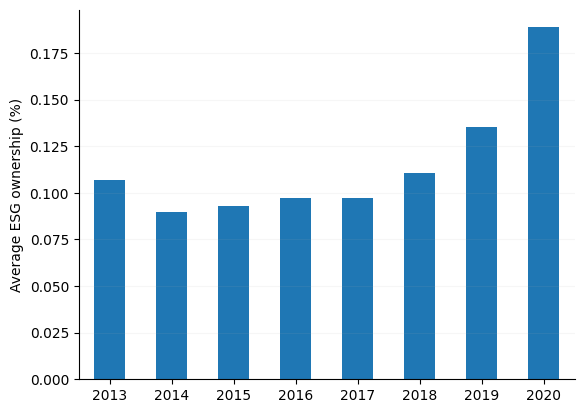

In [210]:
balanced_panel.groupby(balanced_panel.year_month.dt.year)['esg_ownership_percent'].mean().plot(kind='bar')
plt.ylabel("Average ESG ownership (%)")
plt.xlabel("")
plt.grid(axis='y', alpha=0.1)
plt.xticks(rotation=0)

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('./msci_results/mean_esg_ownership_overtime_msci.png', bbox_inches='tight');

In [211]:
balanced_panel.set_index('year_month').loc['2020-09-01'][['esg_ownership', 'industry_adjusted_score']].corr()

,esg_ownership,industry_adjusted_score
esg_ownership,1.000000,0.519687
industry_adjusted_score,0.519687,1.000000


### Change in numerical scores

In [212]:
one_index_before_upgrade = (balanced_panel[balanced_panel['upgrade_dummy']==1].index - 1).tolist()

In [213]:
upgrade_index = balanced_panel[balanced_panel['upgrade_dummy']==1].index.tolist()

In [214]:
upgrades_and_one_index_before = one_index_before_upgrade + upgrade_index

In [215]:
upgrades_and_one_index_before = pd.to_numeric(upgrades_and_one_index_before)

In [216]:
upgrades_and_one_index_before_table = balanced_panel.loc[upgrades_and_one_index_before].sort_index()

In [217]:
upgrades_and_one_index_before_table

,ID,year_month,cusip,nbr_shares,ISIN,asset_name,company_rating,industry_adjusted_score,MthPrc,MthCap,...,time_to_treatment_down_159,time_to_treatment_down_160,time_to_treatment_down_161,time_to_treatment_down_162,time_to_treatment_down_163,time_to_treatment_down_164,time_to_treatment_down_165,time_to_treatment_down_166,time_to_treatment_down_167,time_to_treatment_down_168
68,2,2019-08-01,00105510,625016,US0010551028,AFLAC INC,B,2.7,50.1800,"37,152,418.94",...,0,0,0,0,0,0,0,0,0,0
69,2,2019-09-01,00105510,777090,US0010551028,AFLAC INC,BB,4.2,52.3200,"38,736,838.56",...,0,0,0,0,0,0,0,0,0,0
135,7,2018-02-01,00206R10,515638,US00206R1023,AT&T INC,B,2.6,36.3000,"222,845,700.00",...,0,0,0,0,0,0,0,0,0,0
136,7,2018-03-01,00206R10,2719001,US00206R1023,AT&T INC,BB,3.9,35.6500,"231,554,985.15",...,0,0,0,0,0,0,0,0,0,0
170,8,2013-12-01,00282410,2386910,US0028241000,ABBOTT LABORATORIES,B,2.8,38.3300,"59,265,309.38",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11231,893,2014-11-01,H2906T10,21878,CH0114405324,GARMIN LTD,BB,4.2,57.3000,"10,957,307.10",...,0,0,0,0,0,0,0,0,0,0
11320,896,2015-03-01,H8498910,348419,CH0102993182,TE CONNECTIVITY LTD,BBB,5.0,71.6200,"29,093,548.02",...,0,0,0,0,0,0,0,0,0,0
11321,896,2015-04-01,H8498910,58227,CH0102993182,TE CONNECTIVITY LTD,A,7.0,66.5500,"27,058,631.05",...,0,0,0,0,0,0,0,0,0,0
11422,910,2016-08-01,V7780T10,42954,LR0008862868,ROYAL CARIBBEAN GROUP,BB,3.7,71.1100,"15,307,494.15",...,0,0,0,0,0,0,0,0,0,0


In [218]:
# upgrades_and_one_index_before_table

In [219]:
change_in_ratings_upgrades = upgrades_and_one_index_before_table['industry_adjusted_score'] - upgrades_and_one_index_before_table['industry_adjusted_score'].shift()

In [220]:
change_in_ratings_upgrades = change_in_ratings_upgrades.iloc[1::2]

In [221]:
#similarly for downgrades

In [222]:
one_index_before_downgrade = (balanced_panel[balanced_panel['downgrade_dummy']==1].index - 1).tolist()

In [223]:
downgrade_index = balanced_panel[balanced_panel['downgrade_dummy']==1].index.tolist()

In [224]:
downgrades_and_one_index_before = one_index_before_downgrade + downgrade_index

In [225]:
downgrades_and_one_index_before = pd.to_numeric(downgrades_and_one_index_before)

In [226]:
downgrades_and_one_index_before_table = balanced_panel.loc[downgrades_and_one_index_before].sort_index()

In [227]:
# downgrades_and_one_index_before_table

In [228]:
change_in_ratings_downgrades = downgrades_and_one_index_before_table['industry_adjusted_score'] - downgrades_and_one_index_before_table['industry_adjusted_score'].shift()

In [229]:
change_in_ratings_downgrades = change_in_ratings_downgrades.iloc[1::2]

In [230]:
change_in_ratings_both = pd.concat([change_in_ratings_downgrades, change_in_ratings_upgrades])

In [231]:
change_in_ratings_both = change_in_ratings_both.map('{:.2f}'.format).astype(float)

In [232]:
change_in_ratings_both.min()

-5.7

In [233]:
change_in_ratings_both.max()

3.9

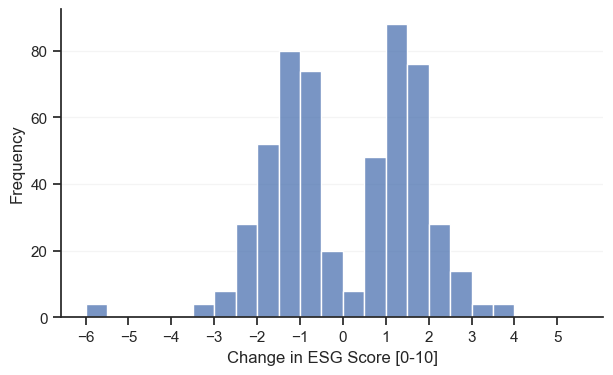

In [234]:
plt.figure(figsize=(7,4))
sns.set_theme(style="ticks")
hist = sns.histplot(change_in_ratings_both, bins=np.arange(-6, 6, 0.5), stat='frequency')
plt.xlabel('Change in ESG Score [0-10]')
plt.xticks(np.arange(-6, 6, 1))
sns.despine()
plt.grid(axis='y', alpha=0.2)
plt.savefig('./msci_results/balanced_sample_msci_change_ratings.png', bbox_inches='tight')

In [235]:
# bin edges
np.round([h.xy[0] for h in hist.patches],2)

array([-6. , -5.5, -5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. ,
       -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,
        5. ])

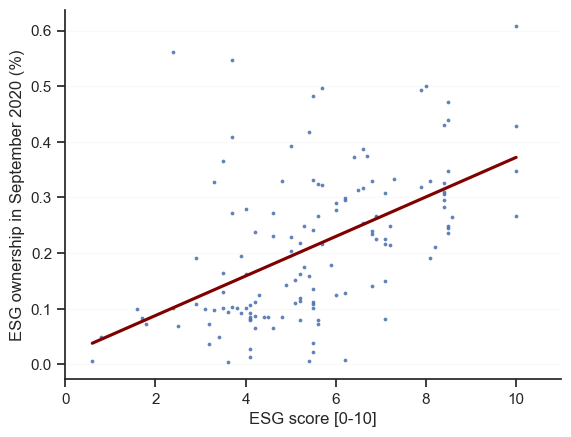

In [236]:
sns.regplot(data=balanced_panel.set_index('year_month').loc['2020-09-01'], 
            x='industry_adjusted_score',
           y=balanced_panel.set_index('year_month').loc['2020-09-01']['esg_ownership_percent'],
           ci=None,
           line_kws={'color':'maroon'}, 
           scatter_kws={"s": 3})

plt.xlabel('ESG score [0-10]')
plt.ylabel('ESG ownership in September 2020 (%)')
plt.grid(axis='y', alpha=0.1)
plt.xlim(0,11)

# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('./msci_results/corr_msci.png', bbox_inches='tight')

In [237]:
balanced_panel[balanced_panel['year_month']=='2020-12-01']['nbr_shares'].mul(
    balanced_panel[balanced_panel['year_month']=='2020-12-01']['MthPrc'].apply(
        lambda x: x.replace(',', '')).astype(float)).sum()/1e9

30.875209270430002

In [238]:
balanced_panel[balanced_panel['year_month']=='2020-12-01']['esg_ownership_percent'].mean()

0.23200783123163962

### Load balanced panel with monthly price data

In [239]:
balanced_panel_with_price= pd.read_stata('./msci_results/balanced_sample_msci_with_price_data.dta')

In [240]:
balanced_panel_with_price.MthPrc = balanced_panel_with_price.MthPrc.apply(lambda x: x.replace(',', '')).astype(float)

In [241]:
balanced_panel_with_price.MthCap = balanced_panel_with_price.MthCap.apply(lambda x: x.replace(',', '')).astype(float)

In [242]:
summary_statistcis_list = ['esg_ownership_percent', 'esg_weight_percent', 'industry_adjusted_score']

In [243]:
summary_statistics_table = balanced_panel_with_price.loc[:, summary_statistcis_list].describe().T.apply(lambda x: x.map('{:.3f}'.format))

In [244]:
summary_statistics_table = summary_statistics_table.rename(index={'esg_ownership_percent': 'ESG ownership (%)',
                                       'esg_weight_percent':'ESG weight (%)', 
                                      'industry_adjusted_score': 'ESG score [0-10]',
                                      'nbr_shares': 'Number of shares', 
                                      'ShrOut':'Shares outstanding',
                                      'MthPrc': 'Monthly stock price',
                                      'MthCap': 'Monthly market cap',
                                      'm_cap_held': 'Market cap held',
                                      'total_mcap_held': 'Total cap held'})

In [245]:
summary_statistics_table = summary_statistics_table.drop(columns=['min', 'max', '25%', '50%', '75%'])

In [246]:
summary_statistics_table

,count,mean,std
ESG ownership (%),11475.000,0.116,0.103
ESG weight (%),11475.000,0.284,0.456
ESG score [0-10],11475.000,4.883,2.113


In [247]:
# latex output
print(summary_statistics_table.to_latex())

\begin{tabular}{llll}
\toprule
{} &      count &   mean &    std \\
\midrule
ESG ownership (\%) &  11475.000 &  0.116 &  0.103 \\
ESG weight (\%)    &  11475.000 &  0.284 &  0.456 \\
ESG score [0-10]  &  11475.000 &  4.883 &  2.113 \\
\bottomrule
\end{tabular}



C:\Users\johnd\AppData\Local\Temp\ipykernel_12816\3328546632.py:2: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



### obtain a list of funds after excluding index funds and ETF'S

In [248]:
test_list = fund_and_holdings_table.fund_name.drop_duplicates()

In [249]:
len(test_list)

197

In [250]:
etfs = test_list[test_list.str.contains('ETF', case=False)]

In [251]:
index_funds =  test_list[test_list.str.contains('index', case=False)]

In [252]:
test_list = test_list.drop(set(etfs.index.to_list() + index_funds.index.to_list()))

In [253]:
test_list_table = test_list.to_frame()

In [254]:
len(test_list_table)

105

In [255]:
test_list_table.to_csv('funds_excluding_index_etf_etn.csv', index=False)

### Number of cohorts

In [256]:
len(balanced_panel_with_price['cohort_up'].drop_duplicates())

59

In [257]:
len(balanced_panel_with_price['cohort_down'].drop_duplicates())

56

### Number of firms in sample

In [258]:
balanced_panel_with_price.ISIN.drop_duplicates()

0        US0010551028
85       US00206R1023
170      US0028241000
255      US00724F1012
340      US0153511094
             ...     
11050    GB00B8W67B19
11135    BMG7496G1033
11220    CH0114405324
11305    CH0102993182
11390    LR0008862868
Name: ISIN, Length: 135, dtype: object

### Number of up and downgrades in sample

In [259]:
balanced_panel_with_price[balanced_panel_with_price['upgrade_dummy']==1]

,ID,year_month,cusip,nbr_shares,ISIN,asset_name,company_rating,industry_adjusted_score,MthPrc,MthCap,...,time_to_treatment_down_159,time_to_treatment_down_160,time_to_treatment_down_161,time_to_treatment_down_162,time_to_treatment_down_163,time_to_treatment_down_164,time_to_treatment_down_165,time_to_treatment_down_166,time_to_treatment_down_167,time_to_treatment_down_168
69,2,2019-09-01,00105510,777090,US0010551028,AFLAC INC,BB,4.2,52.32,3.873684e+07,...,0,0,0,0,0,0,0,0,0,0
136,7,2018-03-01,00206R10,2719001,US00206R1023,AT&T INC,BB,3.9,35.65,2.315550e+08,...,0,0,0,0,0,0,0,0,0,0
171,8,2014-01-01,00282410,2525938,US0028241000,ABBOTT LABORATORIES,BB,3.0,36.66,5.668318e+07,...,0,0,0,0,0,0,0,0,0,0
285,13,2016-06-01,00724F10,951237,US00724F1012,ADOBE INC,BBB,5.1,95.79,4.773129e+07,...,0,0,0,0,0,0,0,0,0,0
386,26,2017-10-01,01535110,187203,US0153511094,ALEXION PHARMACEUTICALS INC,B,1.6,119.66,2.673324e+07,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056,870,2014-06-01,G5480U12,1038051,GB00B8W67B19,LIBERTY GLOBAL PLC,A,5.8,42.31,2.349859e+07,...,0,0,0,0,0,0,0,0,0,0
11212,880,2020-05-01,G7496G10,32218,BMG7496G1033,RENAISSANCERE HOLDINGS LTD,BB,3.2,167.86,7.391547e+06,...,0,0,0,0,0,0,0,0,0,0
11231,893,2014-11-01,H2906T10,21878,CH0114405324,GARMIN LTD,BB,4.2,57.30,1.095731e+07,...,0,0,0,0,0,0,0,0,0,0
11321,896,2015-04-01,H8498910,58227,CH0102993182,TE CONNECTIVITY LTD,A,7.0,66.55,2.705863e+07,...,0,0,0,0,0,0,0,0,0,0


In [260]:
balanced_panel_with_price[balanced_panel_with_price['downgrade_dummy']==1]

,ID,year_month,cusip,nbr_shares,ISIN,asset_name,company_rating,industry_adjusted_score,MthPrc,MthCap,...,time_to_treatment_down_159,time_to_treatment_down_160,time_to_treatment_down_161,time_to_treatment_down_162,time_to_treatment_down_163,time_to_treatment_down_164,time_to_treatment_down_165,time_to_treatment_down_166,time_to_treatment_down_167,time_to_treatment_down_168
35,2,2016-11-01,00105510,362767,US0010551028,AFLAC INC,BB,3.4,71.38,2.913032e+07,...,0,0,0,0,0,0,0,0,0,0
124,7,2017-03-01,00206R10,2106753,US00206R1023,AT&T INC,B,2.6,41.55,2.551822e+08,...,0,0,0,0,0,0,0,0,0,0
194,8,2015-12-01,00282410,3061507,US0028241000,ABBOTT LABORATORIES,B,2.7,44.91,6.699315e+07,...,0,0,0,0,0,0,0,0,0,0
260,13,2014-05-01,00724F10,324544,US00724F1012,ADOBE INC,BBB,4.3,64.54,3.209232e+07,...,0,0,0,0,0,0,0,0,0,0
373,26,2016-09-01,01535110,215957,US0153511094,ALEXION PHARMACEUTICALS INC,B,1.9,122.54,2.743818e+07,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11120,870,2019-10-01,G5480U12,455943,GB00B8W67B19,LIBERTY GLOBAL PLC,BBB,5.5,23.87,1.045215e+07,...,0,0,0,0,0,0,0,0,0,0
11140,880,2014-05-01,G7496G10,6325,BMG7496G1033,RENAISSANCERE HOLDINGS LTD,B,1.7,104.17,4.223989e+06,...,0,0,0,0,0,0,0,0,0,0
11296,893,2020-04-01,H2906T10,225113,CH0114405324,GARMIN LTD,BBB,4.4,81.16,1.550302e+07,...,0,0,0,0,0,0,0,0,0,0
11310,896,2014-05-01,H8498910,71047,CH0102993182,TE CONNECTIVITY LTD,BBB,5.0,59.46,2.430285e+07,...,0,0,0,0,0,0,0,0,0,0


In [261]:
balanced_panel_with_price[(balanced_panel_with_price['upgrade_dummy']==1)|(balanced_panel_with_price['downgrade_dummy']==1)]

,ID,year_month,cusip,nbr_shares,ISIN,asset_name,company_rating,industry_adjusted_score,MthPrc,MthCap,...,time_to_treatment_down_159,time_to_treatment_down_160,time_to_treatment_down_161,time_to_treatment_down_162,time_to_treatment_down_163,time_to_treatment_down_164,time_to_treatment_down_165,time_to_treatment_down_166,time_to_treatment_down_167,time_to_treatment_down_168
35,2,2016-11-01,00105510,362767,US0010551028,AFLAC INC,BB,3.4,71.38,2.913032e+07,...,0,0,0,0,0,0,0,0,0,0
69,2,2019-09-01,00105510,777090,US0010551028,AFLAC INC,BB,4.2,52.32,3.873684e+07,...,0,0,0,0,0,0,0,0,0,0
124,7,2017-03-01,00206R10,2106753,US00206R1023,AT&T INC,B,2.6,41.55,2.551822e+08,...,0,0,0,0,0,0,0,0,0,0
136,7,2018-03-01,00206R10,2719001,US00206R1023,AT&T INC,BB,3.9,35.65,2.315550e+08,...,0,0,0,0,0,0,0,0,0,0
171,8,2014-01-01,00282410,2525938,US0028241000,ABBOTT LABORATORIES,BB,3.0,36.66,5.668318e+07,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11296,893,2020-04-01,H2906T10,225113,CH0114405324,GARMIN LTD,BBB,4.4,81.16,1.550302e+07,...,0,0,0,0,0,0,0,0,0,0
11310,896,2014-05-01,H8498910,71047,CH0102993182,TE CONNECTIVITY LTD,BBB,5.0,59.46,2.430285e+07,...,0,0,0,0,0,0,0,0,0,0
11321,896,2015-04-01,H8498910,58227,CH0102993182,TE CONNECTIVITY LTD,A,7.0,66.55,2.705863e+07,...,0,0,0,0,0,0,0,0,0,0
11412,910,2015-10-01,V7780T10,47294,LR0008862868,ROYAL CARIBBEAN GROUP,BB,3.7,98.35,2.163651e+07,...,0,0,0,0,0,0,0,0,0,0


### Construct dummy variable High ESG score change

In [262]:
change_in_ratings_upgrades = change_in_ratings_upgrades.map('{:.2f}'.format).astype(float)

In [263]:
change_in_ratings_downgrades = abs(change_in_ratings_downgrades.map('{:.2f}'.format).astype(float))

In [264]:
change_in_ratings_upgrades.median()

1.4

In [265]:
change_in_ratings_downgrades.median()

1.3

In [266]:
high_esg_score_change_up = change_in_ratings_upgrades[change_in_ratings_upgrades >= change_in_ratings_upgrades.median()]

In [267]:
high_esg_score_change_down = change_in_ratings_downgrades[change_in_ratings_downgrades >= change_in_ratings_downgrades.median()]

In [268]:
high_scores = pd.concat([high_esg_score_change_up, high_esg_score_change_down]) 

In [269]:
balanced_panel['high_esg_score_change'] = 0

In [270]:
balanced_panel.loc[high_scores.index, 'high_esg_score_change'] = 1

In [271]:
balanced_panel.to_stata('balanced_panel_with_high_score_changes.dta', write_index=False, convert_dates={'year_month':'tm', 'treatment_date':'tm', 'treatment_date_up':'tm', 'treatment_date_down':'tm'})